##  Loading the libraries and dataframes

In [1]:
#!pip install timm

import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import time
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import efficientnet_b0, resnet18 
import timm
from PIL import Image
from sklearn.metrics import precision_recall_fscore_support
import torch.nn.functional as F
from torchvision.utils import save_image
from torch.amp import autocast, GradScaler

# --- GLOBAL CONFIGURATION ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BASE_DIR = '/kaggle/input/final-project-deep-learning-fall-2025/final_project_resources'
IMAGE_DIR = os.path.join(BASE_DIR, 'images')
IMG_SIZE = 256
DISEASE_COLUMNS = ['D', 'G', 'A']
TEAM_ID = "Arshman-Faizan-Marwa" # Change this to your group number

# --- LOAD DATAFRAMES ---
train_df = pd.read_csv(os.path.join(BASE_DIR, 'train.csv'))
val_df = pd.read_csv(os.path.join(BASE_DIR, 'val.csv'))
offsite_test_df = pd.read_csv(os.path.join(BASE_DIR, 'offsite_test.csv'))

print(f"Setup complete. Training on: {DEVICE}")
print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Offsite Test samples: {len(offsite_test_df)}")

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Setup complete. Training on: cuda
Train samples: 800
Validation samples: 200
Offsite Test samples: 200


##  Implement Image Dataset and DataLoaders

In [2]:
class ODIRDataset(Dataset):
    def __init__(self, df, image_dir, mode='train'):
        self.df = df
        self.image_dir = image_dir
        self.mode = mode
        
        if mode == 'train':
            self.image_folder = os.path.join(image_dir, 'train')
        elif mode == 'val':
            self.image_folder = os.path.join(image_dir, 'val')
        elif mode in ['test', 'offsite_test']:
            self.image_folder = os.path.join(image_dir, 'offsite_test') 
        elif mode == 'test_onsite':
            self.image_folder = os.path.join(image_dir, 'onsite_test')
        
        self.transform = self._get_transforms(mode)

    def _get_transforms(self, mode):
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        if mode == 'train':
            return transforms.Compose([
                transforms.Resize((IMG_SIZE, IMG_SIZE)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomRotation(15),
                transforms.ToTensor(),
                normalize
            ])
        return transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            normalize
        ])

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.image_folder, row['id'])
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)
        if self.mode != 'test_onsite': 
            labels = torch.tensor(row[DISEASE_COLUMNS].values.astype(float), dtype=torch.float32)
            return image, labels
        return image, row['id']

# Initialize Loaders
train_loader = DataLoader(ODIRDataset(train_df, IMAGE_DIR, 'train'), batch_size=32, shuffle=True)
val_loader = DataLoader(ODIRDataset(val_df, IMAGE_DIR, 'val'), batch_size=32, shuffle=False)
offsite_loader = DataLoader(ODIRDataset(offsite_test_df, IMAGE_DIR, 'test'), batch_size=32, shuffle=False)

## Data Exploration and Disease Distribution Visualization


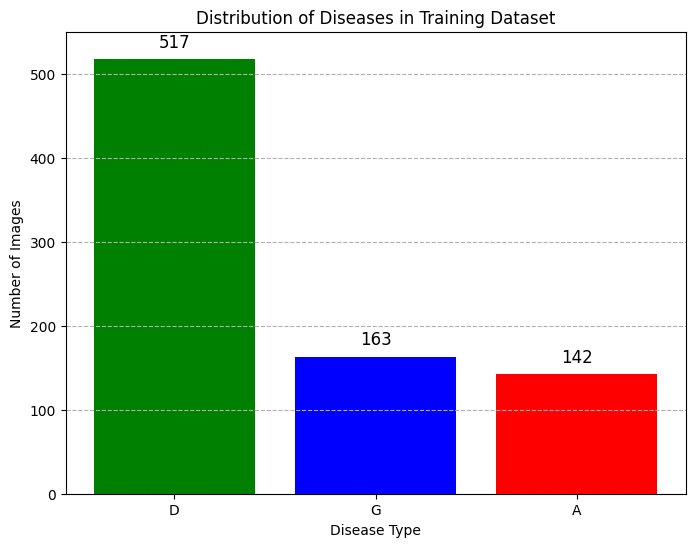

Disease distribution chart saved to: disease_distribution_train.png


In [3]:
import matplotlib.pyplot as plt

# Columns representing the three major diseases
DISEASE_COLUMNS = ['D', 'G', 'A']

# Calculate the count of each disease in the training set
disease_counts = train_df[DISEASE_COLUMNS].sum()

# --- Plotting the Distribution  ---
plt.figure(figsize=(8, 6))
bars = plt.bar(disease_counts.index, disease_counts.values, color=['green', 'blue', 'red'])

# Add the counts on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 10, int(yval), ha='center', va='bottom', fontsize=12)

plt.title('Distribution of Diseases in Training Dataset')
plt.xlabel('Disease Type')
plt.ylabel('Number of Images')
plt.ylim(0, 550) # Set limit based on the document's visualization
plt.grid(axis='y', linestyle='--')

# Save the plot for the report 
CHART_PATH = 'disease_distribution_train.png'
plt.savefig(CHART_PATH)
plt.show()

print(f"Disease distribution chart saved to: {CHART_PATH}")
# Output will confirm the imbalance: D: 517, G: 163, A: 142 [cite: 50, 56, 57]

## VAE Image Generation

In [4]:
# =========================
# Create writable VAE training image directory
# =========================

VAE_TRAIN_DIR = "/kaggle/working/images/train"
os.makedirs(VAE_TRAIN_DIR, exist_ok=True)

print("Writable VAE train directory:", VAE_TRAIN_DIR)

Writable VAE train directory: /kaggle/working/images/train


In [5]:
# =========================
# Copy original training images to working directory
# =========================

import shutil

ORIG_TRAIN_DIR = os.path.join(IMAGE_DIR, "train")

for fname in os.listdir(ORIG_TRAIN_DIR):
    src = os.path.join(ORIG_TRAIN_DIR, fname)
    dst = os.path.join(VAE_TRAIN_DIR, fname)
    if not os.path.exists(dst):
        shutil.copy(src, dst)

print("Original training images copied to working directory.")

Original training images copied to working directory.


In [6]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),   # 128x128
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),  # 64x64
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), # 32x32
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),# 16x16
            nn.ReLU(),
        )

        self.fc_mu = nn.Linear(256 * 16 * 16, latent_dim)
        self.fc_logvar = nn.Linear(256 * 16 * 16, latent_dim)

        # Decoder
        self.fc_dec = nn.Linear(latent_dim, 256 * 16 * 16)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x).view(x.size(0), -1)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_dec(z).view(-1, 256, 16, 16)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

In [7]:
# VAE loss
def vae_loss(recon, x, mu, logvar):
    recon_loss = F.mse_loss(recon, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl


# Dataset for single class
class SingleClassDataset(Dataset):
    def __init__(self, csv_file, image_dir, class_idx):
        self.df = pd.read_csv(csv_file)
        self.df = self.df[self.df.iloc[:, class_idx + 1] == 1]
        self.image_dir = image_dir
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.df.iloc[idx, 0])
        img = Image.open(img_path).convert("RGB")
        return self.transform(img)


def train_vae(class_idx, epochs=30):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    dataset = SingleClassDataset(
        csv_file="/kaggle/input/final-project-deep-learning-fall-2025/final_project_resources/train.csv",
        image_dir="/kaggle/input/final-project-deep-learning-fall-2025/final_project_resources/images/train",
        class_idx=class_idx
    )
    loader = DataLoader(dataset, batch_size=16, shuffle=True)

    model = ConvVAE().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for imgs in loader:
            imgs = imgs.to(device)
            recon, mu, logvar = model(imgs)
            loss = vae_loss(recon, imgs, mu, logvar)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Class {class_idx} | Epoch {epoch+1} | Loss {total_loss/len(dataset):.2f}")

    return model

In [8]:
def generate_images(model, num_images, save_dir, prefix):
    device = next(model.parameters()).device
    model.eval()
    with torch.no_grad():
        for i in range(num_images):
            z = torch.randn(1, 128).to(device)
            img = model.decode(z)
            save_image(img, os.path.join(save_dir, f"{prefix}_vae_{i}.png"))


# Train VAEs
vae_G = train_vae(class_idx=1)  # Glaucoma
vae_A = train_vae(class_idx=2)  # AMD

# Generate images to balance classes
generate_images(vae_G, 354, VAE_TRAIN_DIR, "G")
generate_images(vae_A, 375, VAE_TRAIN_DIR, "A")

Class 1 | Epoch 1 | Loss 24129.28
Class 1 | Epoch 2 | Loss 22947.38
Class 1 | Epoch 3 | Loss 17670.89
Class 1 | Epoch 4 | Loss 10150.20
Class 1 | Epoch 5 | Loss 6943.03
Class 1 | Epoch 6 | Loss 5708.59
Class 1 | Epoch 7 | Loss 4981.78
Class 1 | Epoch 8 | Loss 4569.31
Class 1 | Epoch 9 | Loss 4301.53
Class 1 | Epoch 10 | Loss 4132.60
Class 1 | Epoch 11 | Loss 4003.44
Class 1 | Epoch 12 | Loss 3706.75
Class 1 | Epoch 13 | Loss 3472.86
Class 1 | Epoch 14 | Loss 3319.07
Class 1 | Epoch 15 | Loss 3172.85
Class 1 | Epoch 16 | Loss 2943.74
Class 1 | Epoch 17 | Loss 2735.73
Class 1 | Epoch 18 | Loss 2524.45
Class 1 | Epoch 19 | Loss 2324.47
Class 1 | Epoch 20 | Loss 2206.61
Class 1 | Epoch 21 | Loss 2163.85
Class 1 | Epoch 22 | Loss 1963.97
Class 1 | Epoch 23 | Loss 1781.63
Class 1 | Epoch 24 | Loss 1702.78
Class 1 | Epoch 25 | Loss 1621.01
Class 1 | Epoch 26 | Loss 1550.81
Class 1 | Epoch 27 | Loss 1499.72
Class 1 | Epoch 28 | Loss 1467.68
Class 1 | Epoch 29 | Loss 1408.09
Class 1 | Epoch 30 

In [9]:
df = train_df

new_rows = []

for i in range(354):
    new_rows.append([f"G_vae_{i}.png", 0, 1, 0])

for i in range(375):
    new_rows.append([f"A_vae_{i}.png", 0, 0, 1])

df_vae = pd.concat(
    [df, pd.DataFrame(new_rows, columns=df.columns)],
    ignore_index=True
)

df_vae.to_csv("train_vae.csv", index=False)

print("New training set size:", len(df_vae))

New training set size: 1529


### Initializing the Train Data Loader (again)

In [10]:
# Initialize Loaders
train_df = pd.read_csv("train_vae.csv")
train_loader = DataLoader(ODIRDataset(train_df, "/kaggle/working/images", 'train'), batch_size=32, shuffle=True)

## Updated Disease Distribution Visualization

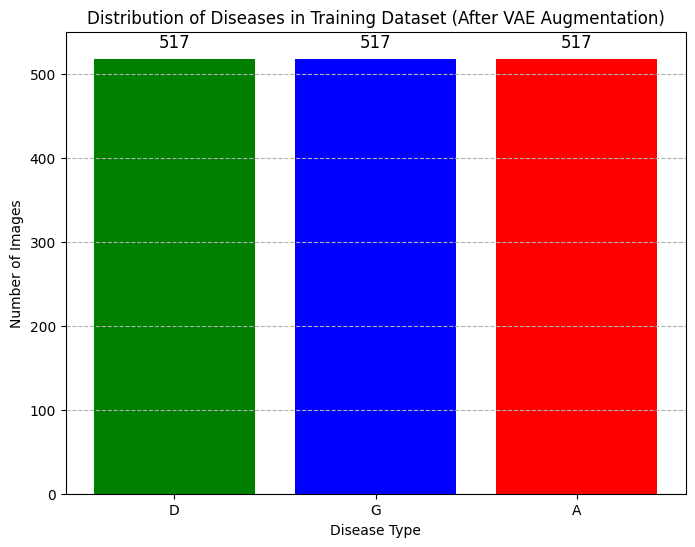

VAE-augmented disease distribution chart saved to: disease_distribution_train_vae.png


In [11]:
# =========================
# Dataset Distribution AFTER VAE Augmentation
# =========================

# Columns representing the three major diseases
DISEASE_COLUMNS = ['D', 'G', 'A']

# Calculate the count of each disease in the training set
disease_counts = train_df[DISEASE_COLUMNS].sum()

plt.figure(figsize=(8, 6))
bars = plt.bar(disease_counts.index, disease_counts.values,
               color=['green', 'blue', 'red'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             yval + 10,
             int(yval),
             ha='center',
             va='bottom',
             fontsize=12)

plt.title('Distribution of Diseases in Training Dataset (After VAE Augmentation)')
plt.xlabel('Disease Type')
plt.ylabel('Number of Images')
plt.ylim(0, 550)
plt.grid(axis='y', linestyle='--')

CHART_PATH_VAE = 'disease_distribution_train_vae.png'
plt.savefig(CHART_PATH_VAE)
plt.show()

print(f"VAE-augmented disease distribution chart saved to: {CHART_PATH_VAE}")


In [12]:
print("Train CSV rows:", len(train_df))
print("Train image files:", len(os.listdir("/kaggle/working/images/train")))

print("Sample image paths:")
for i in range(5):
    print(os.path.join("/kaggle/working/images/train", train_df.iloc[i]['id']))

Train CSV rows: 1529
Train image files: 1529
Sample image paths:
/kaggle/working/images/train/913_right.jpg
/kaggle/working/images/train/281_left.jpg
/kaggle/working/images/train/3981_left.jpg
/kaggle/working/images/train/4449_right.jpg
/kaggle/working/images/train/4497_right.jpg


# Task 1: Transfer Learning Implementation

In [13]:
class TransferModel(nn.Module):
    def __init__(self, backbone, num_classes=3):
        super().__init__()
        self.backbone = backbone
        if hasattr(self.backbone, 'fc'):
            in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
        elif hasattr(self.backbone, 'classifier'):
            in_features = self.backbone.classifier[1].in_features
            self.backbone.classifier = nn.Identity()
        elif hasattr(self.backbone, 'num_features'):  # ViT / Swin
            in_features = backbone.num_features
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        if features.dim() > 2:
            features = features.mean(dim=(2,3))
        return self.classifier(features)

def evaluate_and_print_metrics(model, data_loader, task_name, model_label):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs.to(DEVICE))
            preds = (torch.sigmoid(outputs) > 0.5).int().cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())
    
    all_preds, all_labels = np.concatenate(all_preds), np.concatenate(all_labels)
    precision, recall, fscore, _ = precision_recall_fscore_support(all_labels, all_preds, average=None, zero_division=0)
    avg_fscore = fscore.mean()
    
    print(f"\n--- {task_name} Metrics ({model_label}) ---")
    print(f"Average F-score: {avg_fscore:.4f}")
    diseases = ["DR", "Glaucoma", "AMD"]
    for i in range(3):
        print(f"{diseases[i]}: F-score={fscore[i]:.4f}, Precision={precision[i]:.4f}, Recall={recall[i]:.4f}")
    return avg_fscore

def generate_onsite_submission(model, save_path):
    model.eval()
    template = pd.read_csv(os.path.join(BASE_DIR, 'onsite_test_submission.csv'))
    onsite_loader = DataLoader(ODIRDataset(template, IMAGE_DIR, 'test_onsite'), batch_size=32)
    results = []
    with torch.no_grad():
        for inputs, ids in onsite_loader:
            outputs = model(inputs.to(DEVICE))
            preds = (torch.sigmoid(outputs) > 0.5).int().cpu().numpy()
            for i in range(len(ids)):
                results.append({'id': ids[i], 'D': preds[i,0], 'G': preds[i,1], 'A': preds[i,2]})
    pd.DataFrame(results).to_csv(save_path, index=False)
    print(f"Onsite Submission saved to: {save_path}")

# def load_backbone_only(model, checkpoint_filename):
#     path = os.path.join(BASE_DIR, f'pretrained_backbone/{checkpoint_filename}')
#     ckpt = torch.load(path, map_location=DEVICE)
#     for key in ['classifier.1.weight', 'classifier.1.bias', 'fc.weight', 'fc.bias']:
#         if key in ckpt: del ckpt[key]
#     model.load_state_dict(ckpt, strict=False)
#     return model.to(DEVICE)



def load_backbone_only(model, full_checkpoint_path):
    """
    Loads weights from a FULL path and removes classifier keys.
    """
    # Load the checkpoint directly from the path provided
    checkpoint = torch.load(full_checkpoint_path, map_location=DEVICE)
    
    
    mismatched_keys = ['classifier.1.weight', 'classifier.1.bias', 'fc.weight', 'fc.bias']
    for key in mismatched_keys:
        if key in checkpoint:
            del checkpoint[key]

    model.load_state_dict(checkpoint, strict=False)
    return model.to(DEVICE)

In [14]:
def get_loaded_backbone(model_func, checkpoint_filename):
    """
    Constructs the path once and calls the loader.
    """
    # 1. Instantiate base model
    backbone = model_func(weights=None) 
    
    # 2. Build the FULL path 
    full_path = os.path.join(BASE_DIR, f'pretrained_backbone/{checkpoint_filename}')
    
    # 3. Pass the clean path to the loader
    return load_backbone_only(backbone, full_path)

## Task 1.1 - Baseline Evaluation (Offsite Metrics + Onsite File)

In [15]:
print("Running Task 1.1 Baselines...")

def run_1_1(model_func, ckpt, label):
    model = model_func(num_classes=3).to(DEVICE)
    model.load_state_dict(torch.load(os.path.join(BASE_DIR, f'pretrained_backbone/{ckpt}'), map_location=DEVICE))
    evaluate_and_print_metrics(model, offsite_loader, "Task 1.1", label)
    generate_onsite_submission(model, f"{TEAM_ID}_task1-1_{label}.csv")

run_1_1(efficientnet_b0, 'ckpt_efficientnet_ep50.pt', 'eff')
run_1_1(resnet18, 'ckpt_resnet18_ep50.pt', 'res')

Running Task 1.1 Baselines...

--- Task 1.1 Metrics (eff) ---
Average F-score: 0.5541
DR: F-score=0.6947, Precision=0.7459, Recall=0.6500
Glaucoma: F-score=0.5941, Precision=0.5769, Recall=0.6122
AMD: F-score=0.3736, Precision=0.2464, Recall=0.7727
Onsite Submission saved to: Arshman-Faizan-Marwa_task1-1_eff.csv

--- Task 1.1 Metrics (res) ---
Average F-score: 0.5126
DR: F-score=0.5941, Precision=0.7172, Recall=0.5071
Glaucoma: F-score=0.5169, Precision=0.5750, Recall=0.4694
AMD: F-score=0.4267, Precision=0.3019, Recall=0.7273
Onsite Submission saved to: Arshman-Faizan-Marwa_task1-1_res.csv


## Task 1.2: Frozen Backbone, Fine-Tune Classifier Only

In [16]:
def train_model(model, optimizer, criterion, epochs, model_label, task_label):
    best_f1 = 0
    save_path = f"Arshman-Faizan-Marwa_{task_label}_{model_label}.pt"
    for epoch in range(1, epochs+1):
        model.train()
        for img, lbl in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(img.to(DEVICE)), lbl.to(DEVICE))
            loss.backward(); optimizer.step()
        
        f1 = evaluate_and_print_metrics(model, val_loader, f"Epoch {epoch}", model_label)
        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), save_path)
    return save_path

## Task 1.2(a): Training and Evaluation (EfficientNet)

In [17]:
eff_ckpt_path = os.path.join(BASE_DIR, 'pretrained_backbone/ckpt_efficientnet_ep50.pt')

# --- EfficientNet Task 1.2 ---
model_eff = TransferModel(load_backbone_only(efficientnet_b0(weights=None), eff_ckpt_path)).to(DEVICE)
for param in model_eff.backbone.parameters(): param.requires_grad = False
opt = optim.Adam(model_eff.classifier.parameters(), lr=1e-3)

best_path = train_model(model_eff, opt, nn.BCEWithLogitsLoss(), 25, "EffNet", "task1-2")
model_eff.load_state_dict(torch.load(best_path))
evaluate_and_print_metrics(model_eff, offsite_loader, "Task 1.2 Final", "EffNet")
generate_onsite_submission(model_eff, f"{TEAM_ID}_task1-2_eff.csv")


--- Epoch 1 Metrics (EffNet) ---
Average F-score: 0.6313
DR: F-score=0.7815, Precision=0.7209, Recall=0.8532
Glaucoma: F-score=0.6863, Precision=0.7955, Recall=0.6034
AMD: F-score=0.4262, Precision=0.7647, Recall=0.2955

--- Epoch 2 Metrics (EffNet) ---
Average F-score: 0.4567
DR: F-score=0.7616, Precision=0.6221, Recall=0.9817
Glaucoma: F-score=0.4810, Precision=0.9048, Recall=0.3276
AMD: F-score=0.1277, Precision=1.0000, Recall=0.0682

--- Epoch 3 Metrics (EffNet) ---
Average F-score: 0.5655
DR: F-score=0.7710, Precision=0.6601, Recall=0.9266
Glaucoma: F-score=0.4810, Precision=0.9048, Recall=0.3276
AMD: F-score=0.4444, Precision=0.7368, Recall=0.3182

--- Epoch 4 Metrics (EffNet) ---
Average F-score: 0.5722
DR: F-score=0.7910, Precision=0.6667, Recall=0.9725
Glaucoma: F-score=0.6237, Precision=0.8286, Recall=0.5000
AMD: F-score=0.3019, Precision=0.8889, Recall=0.1818

--- Epoch 5 Metrics (EffNet) ---
Average F-score: 0.6026
DR: F-score=0.8063, Precision=0.7083, Recall=0.9358
Glauco

## Task 1.2(b): Training and Evaluation (ResNet18)

In [18]:
# --- ResNet18 Task 1.2 (Following your EfficientNet Logic) ---
print("Task 1.2 for ResNet18...")
res_ckpt_path = os.path.join(BASE_DIR, 'pretrained_backbone/ckpt_resnet18_ep50.pt')
# 1. Setup Model: Load ResNet18 backbone, strip head, and move to DEVICE
# This uses the specific ResNet checkpoint: ckpt_resnet18_ep50.pt
model_res = TransferModel(
    load_backbone_only(resnet18(weights=None), res_ckpt_path)
).to(DEVICE)

# 2. FREEZE the ResNet backbone (Crucial for Task 1.2)
for param in model_res.backbone.parameters(): 
    param.requires_grad = False

# 3. Setup Optimizer for the classifier head only
opt_res = optim.Adam(model_res.classifier.parameters(), lr=1e-3)

# 4. Train using existing train_model function
# Running for 25 epochs 
best_path_res = train_model(
    model_res, 
    opt_res, 
    nn.BCEWithLogitsLoss(), 
    25, 
    "ResNet", 
    "task1-2"
)

# 5. Load the best saved weights
model_res.load_state_dict(torch.load(best_path_res))

# 6. Final Evaluation on Offsite Test Set
evaluate_and_print_metrics(model_res, offsite_loader, "Task 1.2 Final", "ResNet")

# 7. Generate Onsite Submission for Kaggle (Target: 61.4)
generate_onsite_submission(model_res, f"{TEAM_ID}_task1-2_res.csv")

Task 1.2 for ResNet18...

--- Epoch 1 Metrics (ResNet) ---
Average F-score: 0.3069
DR: F-score=0.7003, Precision=0.5532, Recall=0.9541
Glaucoma: F-score=0.0667, Precision=1.0000, Recall=0.0345
AMD: F-score=0.1538, Precision=0.5000, Recall=0.0909

--- Epoch 2 Metrics (ResNet) ---
Average F-score: 0.3567
DR: F-score=0.7203, Precision=0.5819, Recall=0.9450
Glaucoma: F-score=0.2647, Precision=0.9000, Recall=0.1552
AMD: F-score=0.0851, Precision=0.6667, Recall=0.0455

--- Epoch 3 Metrics (ResNet) ---
Average F-score: 0.4401
DR: F-score=0.7611, Precision=0.7350, Recall=0.7890
Glaucoma: F-score=0.5591, Precision=0.7429, Recall=0.4483
AMD: F-score=0.0000, Precision=0.0000, Recall=0.0000

--- Epoch 4 Metrics (ResNet) ---
Average F-score: 0.4578
DR: F-score=0.7901, Precision=0.7164, Recall=0.8807
Glaucoma: F-score=0.3611, Precision=0.9286, Recall=0.2241
AMD: F-score=0.2222, Precision=0.6000, Recall=0.1364

--- Epoch 5 Metrics (ResNet) ---
Average F-score: 0.3695
DR: F-score=0.7473, Precision=0.6

## Task 1.3 Full fine-tuning

## Task 1.3(a): Training and Evaluation (EfficientNet)

In [ ]:
# --- TASK 1.3: FULL FINE-TUNING ---
print("Task 1.3: Full Fine-Tuning for EfficientNet...")

# 1. Load the model from Task 1.2 Best Weights
eff_backbone = get_loaded_backbone(efficientnet_b0, 'ckpt_efficientnet_ep50.pt')
model_eff_1_3 = TransferModel(eff_backbone).to(DEVICE)
model_eff_1_3.load_state_dict(torch.load('Arshman-Faizan-Marwa_task1-2_EffNet.pt', map_location=DEVICE))

# 2. UNFREEZE EVERYTHING (Crucial for Task 1.3)
for param in model_eff_1_3.parameters():
    param.requires_grad = True

# 3. Setup Optimizer with a MUCH LOWER Learning Rate
optimizer = optim.Adam(model_eff_1_3.parameters(), lr=2e-5)
criterion = nn.BCEWithLogitsLoss()

# 4. Train the model

task1_3_best_path = 'Arshman-Faizan-Marwa_task1-3_EffNet.pt'

best_val_f1 = 0.0
for epoch in range(1, 26): # Run for 25 epochs
    start_time = time.time()
    model_eff_1_3.train()
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(model_eff_1_3(inputs), labels)
        loss.backward()
        optimizer.step()
        
    # Evaluate on Validation Set
    val_f1 = evaluate_and_print_metrics(model_eff_1_3, val_loader, f'Task 1.3 Val (Ep {epoch})', 'EffNet')
    
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model_eff_1_3.state_dict(), task1_3_best_path)
        print(f"-> Task 1.3 Checkpoint Saved! Best Val F1: {best_val_f1:.4f}")

# 5. Final Evaluation and Submission
model_eff_1_3.load_state_dict(torch.load(task1_3_best_path))
evaluate_and_print_metrics(model_eff_1_3, offsite_loader, "Task 1.3 Final", "EffNet")
# Generate the CSV for Kaggle
generate_onsite_submission(model_eff_1_3, 'Arshman-Faizan-Marwa_task1-3_eff.csv')

Task 1.3: Full Fine-Tuning for EfficientNet...

--- Task 1.3 Val (Ep 1) Metrics (EffNet) ---
Average F-score: 0.6513
DR: F-score=0.7967, Precision=0.7273, Recall=0.8807
Glaucoma: F-score=0.6796, Precision=0.7778, Recall=0.6034
AMD: F-score=0.4776, Precision=0.6957, Recall=0.3636
-> Task 1.3 Checkpoint Saved! Best Val F1: 0.6513

--- Task 1.3 Val (Ep 2) Metrics (EffNet) ---
Average F-score: 0.6829
DR: F-score=0.7932, Precision=0.7344, Recall=0.8624
Glaucoma: F-score=0.6800, Precision=0.8095, Recall=0.5862
AMD: F-score=0.5753, Precision=0.7241, Recall=0.4773
-> Task 1.3 Checkpoint Saved! Best Val F1: 0.6829

--- Task 1.3 Val (Ep 3) Metrics (EffNet) ---
Average F-score: 0.6782
DR: F-score=0.7950, Precision=0.7308, Recall=0.8716
Glaucoma: F-score=0.6452, Precision=0.8571, Recall=0.5172
AMD: F-score=0.5946, Precision=0.7333, Recall=0.5000

--- Task 1.3 Val (Ep 4) Metrics (EffNet) ---
Average F-score: 0.6960
DR: F-score=0.7879, Precision=0.7459, Recall=0.8349
Glaucoma: F-score=0.7000, Precis

## Task 1.3(b): Training and Evaluation (ResNet18)

In [20]:
# --- TASK 1.3: FULL FINE-TUNING FOR RESNET18 ---
print("Task 1.3: Full Fine-Tuning for ResNet18...")

# 1. Load the architecture and ResNet baseline backbone
# Using the path logic that works for your environment
res_ckpt_path = os.path.join(BASE_DIR, 'pretrained_backbone/ckpt_resnet18_ep50.pt')
res_backbone = load_backbone_only(resnet18(weights=None), res_ckpt_path)
model_res_1_3 = TransferModel(res_backbone).to(DEVICE)

# 2. LOAD YOUR BEST WEIGHTS FROM RESNET TASK 1.2
# This filename should match the save_path from your ResNet 1.2 run
task1_2_res_weights = 'Arshman-Faizan-Marwa_task1-2_ResNet.pt' 

if os.path.exists(task1_2_res_weights):
    model_res_1_3.load_state_dict(torch.load(task1_2_res_weights, map_location=DEVICE))
    print(f"Successfully loaded ResNet Task 1.2 weights.")
else:
    print(f"ERROR: {task1_2_res_weights} not found. Please check the filename.")

# 3. UNFREEZE EVERYTHING
for param in model_res_1_3.parameters():
    param.requires_grad = True

# 4. Setup Optimizer with a LOW Learning Rate (1e-5 or 2e-5)
# We use a low LR so we don't destroy the pre-trained features
optimizer = optim.Adam(model_res_1_3.parameters(), lr=2e-5)
criterion = nn.BCEWithLogitsLoss()

# 5. Training Loop
task1_3_res_best_path = 'Arshman-Faizan-Marwa_task1-3_ResNet.pt'
best_val_f1 = 0.0

for epoch in range(1, 26): # Running for 25 epochs
    model_res_1_3.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(model_res_1_3(inputs), labels)
        loss.backward()
        optimizer.step()
        
    # Evaluate on Validation Set
    val_f1 = evaluate_and_print_metrics(model_res_1_3, val_loader, f'Task 1.3 Val (Ep {epoch})', 'ResNet')
    
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model_res_1_3.state_dict(), task1_3_res_best_path)
        print(f"-> Task 1.3 ResNet Checkpoint Saved! Best Val F1: {best_val_f1:.4f}")

# 6. Final Evaluation and Submission (Target: 78.8)
model_res_1_3.load_state_dict(torch.load(task1_3_res_best_path))
print("\n--- Final Metrics for ResNet Task 1.3 ---")
evaluate_and_print_metrics(model_res_1_3, offsite_loader, "Task 1.3 Final", "ResNet")
generate_onsite_submission(model_res_1_3, f"{TEAM_ID}_task1-3_res.csv")

Task 1.3: Full Fine-Tuning for ResNet18...
Successfully loaded ResNet Task 1.2 weights.

--- Task 1.3 Val (Ep 1) Metrics (ResNet) ---
Average F-score: 0.5377
DR: F-score=0.7538, Precision=0.6490, Recall=0.8991
Glaucoma: F-score=0.6047, Precision=0.9286, Recall=0.4483
AMD: F-score=0.2545, Precision=0.6364, Recall=0.1591
-> Task 1.3 ResNet Checkpoint Saved! Best Val F1: 0.5377

--- Task 1.3 Val (Ep 2) Metrics (ResNet) ---
Average F-score: 0.5891
DR: F-score=0.7869, Precision=0.7111, Recall=0.8807
Glaucoma: F-score=0.6947, Precision=0.8919, Recall=0.5690
AMD: F-score=0.2857, Precision=0.6667, Recall=0.1818
-> Task 1.3 ResNet Checkpoint Saved! Best Val F1: 0.5891

--- Task 1.3 Val (Ep 3) Metrics (ResNet) ---
Average F-score: 0.5793
DR: F-score=0.7857, Precision=0.6923, Recall=0.9083
Glaucoma: F-score=0.7021, Precision=0.9167, Recall=0.5690
AMD: F-score=0.2500, Precision=0.5833, Recall=0.1591

--- Task 1.3 Val (Ep 4) Metrics (ResNet) ---
Average F-score: 0.6025
DR: F-score=0.7871, Precision

# Task 2: Loss Functions

## Function: Focal Loss Function (multi-label, logits)

In [21]:
class FocalLossMultiLabel(nn.Module):
    """
    Multi-label focal loss built on BCE-with-logits.
    Works with logits of shape [B, C] and targets in {0,1} of shape [B, C].

    gamma: focusing parameter (typical: 2.0)
    alpha: balancing factor:
      - float in (0,1): same alpha for all classes (applied to positive term)
      - list/np/torch of shape [C]: per-class alpha for positive term
    reduction: 'mean' or 'sum' or 'none'
    """
    def __init__(self, gamma=2.0, alpha=0.25, reduction="mean"):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.bce = nn.BCEWithLogitsLoss(reduction="none")

    def forward(self, logits, targets):
        # BCE per element
        bce_loss = self.bce(logits, targets)  # [B, C]

        # Probabilities
        probs = torch.sigmoid(logits)  # [B, C]
        pt = probs * targets + (1 - probs) * (1 - targets)  # prob of the true label

        # Alpha weighting (optional)
        if self.alpha is None:
            alpha_t = 1.0
        else:
            if isinstance(self.alpha, (float, int)):
                alpha_pos = torch.full_like(targets, float(self.alpha))
            else:
                alpha_tensor = torch.tensor(self.alpha, device=logits.device, dtype=logits.dtype).view(1, -1)
                alpha_pos = alpha_tensor.expand_as(targets)
            alpha_t = alpha_pos * targets + (1 - alpha_pos) * (1 - targets)

        focal_factor = (1 - pt).pow(self.gamma)
        loss = alpha_t * focal_factor * bce_loss  # [B, C]

        if self.reduction == "mean":
            return loss.mean()
        if self.reduction == "sum":
            return loss.sum()
        return loss

## Function: Class-Balanced Loss (re-weight BCE by class frequency)

In [22]:
class ClassBalancedBCELoss(nn.Module):
    """
    Class-Balanced BCE (multi-label).
    Uses "effective number of samples" weighting (Cui et al.) for *positive labels* per class,
    then applies that weight to the per-class BCE terms.

    beta close to 1.0 (e.g., 0.999) is typical when dataset is not huge.
    """
    def __init__(self, samples_per_class, beta=0.999, reduction="mean"):
        super().__init__()
        self.beta = beta
        self.reduction = reduction
        self.bce = nn.BCEWithLogitsLoss(reduction="none")

        spc = torch.tensor(samples_per_class, dtype=torch.float32)
        effective_num = 1.0 - torch.pow(torch.tensor(beta), spc)
        weights = (1.0 - beta) / (effective_num + 1e-12)  # [C]
        # Normalize weights to keep loss scale stable
        weights = weights / weights.sum() * len(weights)

        self.register_buffer("pos_weights", weights)  # [C]

    def forward(self, logits, targets):
        # BCE per element [B, C]
        bce_loss = self.bce(logits, targets)

        # Apply class-balanced weight to positive labels only
        # weight matrix: targets==1 gets pos_weights[c], targets==0 gets 1.0
        w = targets * self.pos_weights.view(1, -1) + (1 - targets) * 1.0
        loss = w * bce_loss

        if self.reduction == "mean":
            return loss.mean()
        if self.reduction == "sum":
            return loss.sum()
        return loss

## Compute class stats from training dataset

In [23]:
def get_samples_per_class_from_df(df, disease_cols):
    # For multi-label, "samples_per_class" = number of positives for each class
    counts = df[disease_cols].sum().values.astype(np.float32)  # [C]
    # Avoid zeros (shouldn't happen here, but keep safe)
    counts = np.clip(counts, 1.0, None)
    return counts

## Training loop: full fine-tuning using a custom loss

In [24]:
def train_full_finetune_with_loss(
    model,
    loss_fn,
    epochs,
    lr,
    model_label,
    task_label,
    save_path,
):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scaler = GradScaler()
    best_val_f1 = -1.0

    for epoch in range(1, epochs + 1):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            # ---------- AMP FORWARD ----------
            with autocast(device_type=DEVICE.type):
                logits = model(inputs)
                loss = loss_fn(logits, labels)

            # ---------- AMP BACKWARD ----------
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        val_f1 = evaluate_and_print_metrics(model, val_loader, f"{task_label} Val (Ep {epoch})", model_label)

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), save_path)
            print(f"-> Saved best checkpoint to {save_path} | Best Val F1: {best_val_f1:.4f}")

    return save_path

## Shared statistics for losses

In [25]:
# --- shared statistics for losses ---
pos_counts = train_df[DISEASE_COLUMNS].sum().values.astype(np.float32)
total = float(len(train_df))
pos_rate = pos_counts / total

# Per-class alpha heuristic (more weight for minority positives), normalized
alpha_per_class = (1.0 - pos_rate)
alpha_per_class = (alpha_per_class / alpha_per_class.sum()) * len(alpha_per_class)

samples_per_class = get_samples_per_class_from_df(train_df, DISEASE_COLUMNS)

## Task 2.1(a): Training and Evaluation (EfficientNet)

In [26]:
# -----------------------------
# TASK 2.1: Focal Loss (EffNet)
# -----------------------------
print("\n--- TASK 2.1: Focal Loss (EffNet) ---")

eff_ckpt_path = os.path.join(BASE_DIR, 'pretrained_backbone/ckpt_efficientnet_ep50.pt')
eff_backbone = load_backbone_only(efficientnet_b0(weights=None), eff_ckpt_path)
model_eff_2_1 = TransferModel(eff_backbone).to(DEVICE)

for p in model_eff_2_1.parameters():
    p.requires_grad = True

criterion_focal = FocalLossMultiLabel(gamma=2.0, alpha=0.25, reduction="mean")

task2_1_eff_best_path = 'Arshman-Faizan-Marwa_task2-1_EffNet.pt'
train_full_finetune_with_loss(
    model=model_eff_2_1,
    loss_fn=criterion_focal,
    epochs=25,
    lr=2e-5,
    model_label="EffNet",
    task_label="Task 2.1 (Focal)",
    save_path=task2_1_eff_best_path
)

model_eff_2_1.load_state_dict(torch.load(task2_1_eff_best_path, map_location=DEVICE))
print("\n--- Task 2.1 Final Metrics (Offsite) EffNet ---")
evaluate_and_print_metrics(model_eff_2_1, offsite_loader, "Task 2.1 Final (Offsite)", "EffNet")
generate_onsite_submission(model_eff_2_1, f"{TEAM_ID}_task2-1eff.csv")


--- TASK 2.1: Focal Loss (EffNet) ---

--- Task 2.1 (Focal) Val (Ep 1) Metrics (EffNet) ---
Average F-score: 0.1351
DR: F-score=0.4054, Precision=0.7692, Recall=0.2752
Glaucoma: F-score=0.0000, Precision=0.0000, Recall=0.0000
AMD: F-score=0.0000, Precision=0.0000, Recall=0.0000
-> Saved best checkpoint to Arshman-Faizan-Marwa_task2-1_EffNet.pt | Best Val F1: 0.1351

--- Task 2.1 (Focal) Val (Ep 2) Metrics (EffNet) ---
Average F-score: 0.2105
DR: F-score=0.5977, Precision=0.8000, Recall=0.4771
Glaucoma: F-score=0.0339, Precision=1.0000, Recall=0.0172
AMD: F-score=0.0000, Precision=0.0000, Recall=0.0000
-> Saved best checkpoint to Arshman-Faizan-Marwa_task2-1_EffNet.pt | Best Val F1: 0.2105

--- Task 2.1 (Focal) Val (Ep 3) Metrics (EffNet) ---
Average F-score: 0.3964
DR: F-score=0.6374, Precision=0.7945, Recall=0.5321
Glaucoma: F-score=0.5517, Precision=0.8276, Recall=0.4138
AMD: F-score=0.0000, Precision=0.0000, Recall=0.0000
-> Saved best checkpoint to Arshman-Faizan-Marwa_task2-1_Eff

## Task 2.1(b): Training and Evaluation (ResNet18)

In [27]:
# -----------------------------
# TASK 2.1: Focal Loss (ResNet)
# -----------------------------
print("\n--- TASK 2.1: Focal Loss (ResNet) ---")

res_ckpt_path = os.path.join(BASE_DIR, 'pretrained_backbone/ckpt_resnet18_ep50.pt')
res_backbone = load_backbone_only(resnet18(weights=None), res_ckpt_path)
model_res_2_1 = TransferModel(res_backbone).to(DEVICE)

for p in model_res_2_1.parameters():
    p.requires_grad = True

criterion_focal = FocalLossMultiLabel(gamma=2.0, alpha=0.25, reduction="mean")

task2_1_res_best_path = 'Arshman-Faizan-Marwa_task2-1_ResNet.pt'
train_full_finetune_with_loss(
    model=model_res_2_1,
    loss_fn=criterion_focal,
    epochs=25,
    lr=2e-5,
    model_label="ResNet",
    task_label="Task 2.1 (Focal)",
    save_path=task2_1_res_best_path
)

model_res_2_1.load_state_dict(torch.load(task2_1_res_best_path, map_location=DEVICE))
print("\n--- Task 2.1 Final Metrics (Offsite) ResNet ---")
evaluate_and_print_metrics(model_res_2_1, offsite_loader, "Task 2.1 Final (Offsite)", "ResNet")
generate_onsite_submission(model_res_2_1, f"{TEAM_ID}_task2-1res.csv")


--- TASK 2.1: Focal Loss (ResNet) ---

--- Task 2.1 (Focal) Val (Ep 1) Metrics (ResNet) ---
Average F-score: 0.1127
DR: F-score=0.3382, Precision=0.8519, Recall=0.2110
Glaucoma: F-score=0.0000, Precision=0.0000, Recall=0.0000
AMD: F-score=0.0000, Precision=0.0000, Recall=0.0000
-> Saved best checkpoint to Arshman-Faizan-Marwa_task2-1_ResNet.pt | Best Val F1: 0.1127

--- Task 2.1 (Focal) Val (Ep 2) Metrics (ResNet) ---
Average F-score: 0.2553
DR: F-score=0.7320, Precision=0.8353, Recall=0.6514
Glaucoma: F-score=0.0339, Precision=1.0000, Recall=0.0172
AMD: F-score=0.0000, Precision=0.0000, Recall=0.0000
-> Saved best checkpoint to Arshman-Faizan-Marwa_task2-1_ResNet.pt | Best Val F1: 0.2553

--- Task 2.1 (Focal) Val (Ep 3) Metrics (ResNet) ---
Average F-score: 0.3451
DR: F-score=0.7166, Precision=0.8590, Recall=0.6147
Glaucoma: F-score=0.3188, Precision=1.0000, Recall=0.1897
AMD: F-score=0.0000, Precision=0.0000, Recall=0.0000
-> Saved best checkpoint to Arshman-Faizan-Marwa_task2-1_Res

## Task 2.2(a): Training and Evaluation (EfficientNet)

In [28]:
# --------------------------------------
# TASK 2.2: Class-Balanced BCE (EffNet)
# --------------------------------------
print("\n--- TASK 2.2: Class-Balanced BCE (EffNet) ---")

eff_ckpt_path = os.path.join(BASE_DIR, 'pretrained_backbone/ckpt_efficientnet_ep50.pt')
eff_backbone = load_backbone_only(efficientnet_b0(weights=None), eff_ckpt_path)
model_eff_2_2 = TransferModel(eff_backbone).to(DEVICE)

for p in model_eff_2_2.parameters():
    p.requires_grad = True

criterion_cb = ClassBalancedBCELoss(samples_per_class=samples_per_class, beta=0.999, reduction="mean").to(DEVICE)

task2_2_eff_best_path = 'Arshman-Faizan-Marwa_task2-2_EffNet.pt'
train_full_finetune_with_loss(
    model=model_eff_2_2,
    loss_fn=criterion_cb,
    epochs=25,
    lr=2e-5,
    model_label="EffNet",
    task_label="Task 2.2 (ClassBalanced)",
    save_path=task2_2_eff_best_path
)

model_eff_2_2.load_state_dict(torch.load(task2_2_eff_best_path, map_location=DEVICE))
print("\n--- Task 2.2 Final Metrics (Offsite) EffNet ---")
evaluate_and_print_metrics(model_eff_2_2, offsite_loader, "Task 2.2 Final (Offsite)", "EffNet")
generate_onsite_submission(model_eff_2_2, f"{TEAM_ID}_task2-2eff.csv")



--- TASK 2.2: Class-Balanced BCE (EffNet) ---

--- Task 2.2 (ClassBalanced) Val (Ep 1) Metrics (EffNet) ---
Average F-score: 0.3522
DR: F-score=0.7424, Precision=0.6323, Recall=0.8991
Glaucoma: F-score=0.3143, Precision=0.9167, Recall=0.1897
AMD: F-score=0.0000, Precision=0.0000, Recall=0.0000
-> Saved best checkpoint to Arshman-Faizan-Marwa_task2-2_EffNet.pt | Best Val F1: 0.3522

--- Task 2.2 (ClassBalanced) Val (Ep 2) Metrics (EffNet) ---
Average F-score: 0.4308
DR: F-score=0.7491, Precision=0.6205, Recall=0.9450
Glaucoma: F-score=0.5432, Precision=0.9565, Recall=0.3793
AMD: F-score=0.0000, Precision=0.0000, Recall=0.0000
-> Saved best checkpoint to Arshman-Faizan-Marwa_task2-2_EffNet.pt | Best Val F1: 0.4308

--- Task 2.2 (ClassBalanced) Val (Ep 3) Metrics (EffNet) ---
Average F-score: 0.4627
DR: F-score=0.7566, Precision=0.6392, Recall=0.9266
Glaucoma: F-score=0.6316, Precision=0.8108, Recall=0.5172
AMD: F-score=0.0000, Precision=0.0000, Recall=0.0000
-> Saved best checkpoint to 

## Task 2.2(b): Training and Evaluation (ResNet18)

In [29]:
# --------------------------------------
# TASK 2.2: Class-Balanced BCE (ResNet)
# --------------------------------------
print("\n--- TASK 2.2: Class-Balanced BCE (ResNet) ---")

res_ckpt_path = os.path.join(BASE_DIR, 'pretrained_backbone/ckpt_resnet18_ep50.pt')
res_backbone = load_backbone_only(resnet18(weights=None), res_ckpt_path)
model_res_2_2 = TransferModel(res_backbone).to(DEVICE)

for p in model_res_2_2.parameters():
    p.requires_grad = True

criterion_cb = ClassBalancedBCELoss(samples_per_class=samples_per_class, beta=0.999, reduction="mean").to(DEVICE)

task2_2_res_best_path = 'Arshman-Faizan-Marwa_task2-2_ResNet.pt'
train_full_finetune_with_loss(
    model=model_res_2_2,
    loss_fn=criterion_cb,
    epochs=25,
    lr=2e-5,
    model_label="ResNet",
    task_label="Task 2.2 (ClassBalanced)",
    save_path=task2_2_res_best_path
)

model_res_2_2.load_state_dict(torch.load(task2_2_res_best_path, map_location=DEVICE))
print("\n--- Task 2.2 Final Metrics (Offsite) ResNet ---")
evaluate_and_print_metrics(model_res_2_2, offsite_loader, "Task 2.2 Final (Offsite)", "ResNet")
generate_onsite_submission(model_res_2_2, f"{TEAM_ID}_task2-2res.csv")


--- TASK 2.2: Class-Balanced BCE (ResNet) ---

--- Task 2.2 (ClassBalanced) Val (Ep 1) Metrics (ResNet) ---
Average F-score: 0.2497
DR: F-score=0.7153, Precision=0.5754, Recall=0.9450
Glaucoma: F-score=0.0339, Precision=1.0000, Recall=0.0172
AMD: F-score=0.0000, Precision=0.0000, Recall=0.0000
-> Saved best checkpoint to Arshman-Faizan-Marwa_task2-2_ResNet.pt | Best Val F1: 0.2497

--- Task 2.2 (ClassBalanced) Val (Ep 2) Metrics (ResNet) ---
Average F-score: 0.3785
DR: F-score=0.7465, Precision=0.6057, Recall=0.9725
Glaucoma: F-score=0.3889, Precision=1.0000, Recall=0.2414
AMD: F-score=0.0000, Precision=0.0000, Recall=0.0000
-> Saved best checkpoint to Arshman-Faizan-Marwa_task2-2_ResNet.pt | Best Val F1: 0.3785

--- Task 2.2 (ClassBalanced) Val (Ep 3) Metrics (ResNet) ---
Average F-score: 0.4820
DR: F-score=0.7663, Precision=0.6579, Recall=0.9174
Glaucoma: F-score=0.6353, Precision=1.0000, Recall=0.4655
AMD: F-score=0.0444, Precision=1.0000, Recall=0.0227
-> Saved best checkpoint to 

# Task 3: Attention Mechanisms (SE + Multi-head Attention)

## Function: Squeeze-and-Excitation

In [30]:
class SEBlock(nn.Module):
    """
    Channel attention (Squeeze-and-Excitation).
    Input:  (B, C, H, W)
    Output: (B, C, H, W)
    """
    def __init__(self, channels: int, reduction: int = 16):
        super().__init__()
        hidden = max(channels // reduction, 4)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, hidden, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, channels, bias=True),
            nn.Sigmoid(),
        )

    def forward(self, x):
        b, c, _, _ = x.shape
        s = self.pool(x).view(b, c)         # (B, C)
        w = self.fc(s).view(b, c, 1, 1)     # (B, C, 1, 1)
        return x * w

## Function: Multi-head Attention

In [31]:
class SpatialMHABlock(nn.Module):
    """
    Self-attention over spatial tokens.
    Treats each spatial position as a token with embedding dim = C.
    Input:  (B, C, H, W)
    Output: (B, C, H, W)
    """
    def __init__(self, channels: int, num_heads: int = 8, dropout: float = 0.0):
        super().__init__()
        assert channels % num_heads == 0, "channels must be divisible by num_heads"
        self.norm = nn.LayerNorm(channels)
        self.mha = nn.MultiheadAttention(embed_dim=channels, num_heads=num_heads,
                                         dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        b, c, h, w = x.shape
        # (B, C, H, W) -> (B, HW, C)
        tokens = x.view(b, c, h * w).transpose(1, 2)
        tokens_n = self.norm(tokens)
        attn_out, _ = self.mha(tokens_n, tokens_n, tokens_n, need_weights=False)
        tokens = tokens + self.dropout(attn_out)  # residual
        # (B, HW, C) -> (B, C, H, W)
        return tokens.transpose(1, 2).view(b, c, h, w)

## Attention-enabled models for ResNet18 
### (uses your pretrained backbone checkpoints via load_backbone_only())

In [32]:
class ResNet18WithAttention(nn.Module):
    def __init__(self, resnet_backbone: nn.Module, attention: str = "none",
                 num_classes: int = 3, se_reduction: int = 16, mha_heads: int = 8):
        super().__init__()
        self.backbone = resnet_backbone  # already loaded with your checkpoint
        self.feature_extractor = nn.Sequential(
            self.backbone.conv1,
            self.backbone.bn1,
            self.backbone.relu,
            self.backbone.maxpool,
            self.backbone.layer1,
            self.backbone.layer2,
            self.backbone.layer3,
            self.backbone.layer4,
        )

        c = 512  # ResNet18 layer4 output channels
        if attention.lower() == "se":
            self.attn = SEBlock(c, reduction=se_reduction)
        elif attention.lower() == "mha":
            self.attn = SpatialMHABlock(c, num_heads=mha_heads, dropout=0.0)
        else:
            self.attn = nn.Identity()

        self.pool = nn.AdaptiveAvgPool2d(1)

        # same style head as your TransferModel
        self.classifier = nn.Sequential(
            nn.Linear(c, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        f = self.feature_extractor(x)       # (B, 512, H, W)
        f = self.attn(f)
        f = self.pool(f).flatten(1)         # (B, 512)
        return self.classifier(f)

## Attention-enabled models for EfficientNetB0 
### (uses your pretrained backbone checkpoints via load_backbone_only())

In [33]:
class EfficientNetB0WithAttention(nn.Module):
    def __init__(self, eff_backbone: nn.Module, attention: str = "none",
                 num_classes: int = 3, se_reduction: int = 16, mha_heads: int = 8):
        super().__init__()
        self.backbone = eff_backbone  # already loaded with your checkpoint
        self.features = self.backbone.features

        c = 1280  # EfficientNetB0 final feature channels
        if attention.lower() == "se":
            self.attn = SEBlock(c, reduction=se_reduction)
        elif attention.lower() == "mha":
            self.attn = SpatialMHABlock(c, num_heads=mha_heads, dropout=0.0)
        else:
            self.attn = nn.Identity()

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.2)

        self.classifier = nn.Sequential(
            nn.Linear(c, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        f = self.features(x)                # (B, 1280, H, W)
        f = self.attn(f)
        f = self.pool(f).flatten(1)         # (B, 1280)
        f = self.dropout(f)
        return self.classifier(f)

## Loss Choice

In [34]:
# ------------------------------------------------------------
# Loss choice: prefer your ClassBalancedBCELoss if available,
# else fallback to BCEWithLogitsLoss.
# ------------------------------------------------------------
def get_task3_loss():
    # If you already defined ClassBalancedBCELoss in Task 2, use it.
    if "ClassBalancedBCELoss" in globals():
        samples_per_class = train_df[DISEASE_COLUMNS].sum().values.astype(np.float32)
        return ClassBalancedBCELoss(samples_per_class=samples_per_class, beta=0.999, reduction="mean").to(DEVICE)
    return nn.BCEWithLogitsLoss()

## Task 3.1(a): Training and Evaluation (EfficientNet)

In [35]:
print("\n--- TASK 3.1: SE Attention (EffNet) ---")

task3_criterion = get_task3_loss()

eff_ckpt_path = os.path.join(BASE_DIR, 'pretrained_backbone/ckpt_efficientnet_ep50.pt')
eff_backbone = load_backbone_only(efficientnet_b0(weights=None), eff_ckpt_path)

model_eff_3_1 = EfficientNetB0WithAttention(
    eff_backbone=eff_backbone,
    attention="se",
    num_classes=3,
    se_reduction=16,
    mha_heads=8
).to(DEVICE)

for p in model_eff_3_1.parameters():
    p.requires_grad = True

task3_1_eff_best_path = "Arshman-Faizan-Marwa_task3-1_EffNet.pt"

train_full_finetune_with_loss(
    model=model_eff_3_1,
    loss_fn=task3_criterion,
    epochs=25,
    lr=2e-5,
    model_label="EffNet",
    task_label="Task 3.1 SE",
    save_path=task3_1_eff_best_path
)

model_eff_3_1.load_state_dict(torch.load(task3_1_eff_best_path, map_location=DEVICE))
evaluate_and_print_metrics(model_eff_3_1, offsite_loader, "Task 3.1 Final Offsite", "EffNet")
generate_onsite_submission(model_eff_3_1, f"{TEAM_ID}_task3-1eff.csv")



--- TASK 3.1: SE Attention (EffNet) ---

--- Task 3.1 SE Val (Ep 1) Metrics (EffNet) ---
Average F-score: 0.2528
DR: F-score=0.7584, Precision=0.6375, Recall=0.9358
Glaucoma: F-score=0.0000, Precision=0.0000, Recall=0.0000
AMD: F-score=0.0000, Precision=0.0000, Recall=0.0000
-> Saved best checkpoint to Arshman-Faizan-Marwa_task3-1_EffNet.pt | Best Val F1: 0.2528

--- Task 3.1 SE Val (Ep 2) Metrics (EffNet) ---
Average F-score: 0.4113
DR: F-score=0.7528, Precision=0.6296, Recall=0.9358
Glaucoma: F-score=0.4810, Precision=0.9048, Recall=0.3276
AMD: F-score=0.0000, Precision=0.0000, Recall=0.0000
-> Saved best checkpoint to Arshman-Faizan-Marwa_task3-1_EffNet.pt | Best Val F1: 0.4113

--- Task 3.1 SE Val (Ep 3) Metrics (EffNet) ---
Average F-score: 0.4631
DR: F-score=0.7576, Precision=0.6452, Recall=0.9174
Glaucoma: F-score=0.6316, Precision=0.8108, Recall=0.5172
AMD: F-score=0.0000, Precision=0.0000, Recall=0.0000
-> Saved best checkpoint to Arshman-Faizan-Marwa_task3-1_EffNet.pt | Best

## Task 3.1(b): Training and Evaluation (ResNet18)

In [36]:
print("\n--- TASK 3.1: SE Attention (ResNet) ---")

task3_criterion = get_task3_loss()

res_ckpt_path = os.path.join(BASE_DIR, 'pretrained_backbone/ckpt_resnet18_ep50.pt')
res_backbone = load_backbone_only(resnet18(weights=None), res_ckpt_path)

model_res_3_1 = ResNet18WithAttention(
    resnet_backbone=res_backbone,
    attention="se",
    num_classes=3,
    se_reduction=16,
    mha_heads=8
).to(DEVICE)

for p in model_res_3_1.parameters():
    p.requires_grad = True

task3_1_res_best_path = "Arshman-Faizan-Marwa_task3-1_ResNet.pt"

train_full_finetune_with_loss(
    model=model_res_3_1,
    loss_fn=task3_criterion,
    epochs=25,
    lr=2e-5,
    model_label="ResNet",
    task_label="Task 3.1 SE",
    save_path=task3_1_res_best_path
)

model_res_3_1.load_state_dict(torch.load(task3_1_res_best_path, map_location=DEVICE))
evaluate_and_print_metrics(model_res_3_1, offsite_loader, "Task 3.1 Final Offsite", "ResNet")
generate_onsite_submission(model_res_3_1, f"{TEAM_ID}_task3-1res.csv")


--- TASK 3.1: SE Attention (ResNet) ---

--- Task 3.1 SE Val (Ep 1) Metrics (ResNet) ---
Average F-score: 0.2398
DR: F-score=0.7195, Precision=0.5619, Recall=1.0000
Glaucoma: F-score=0.0000, Precision=0.0000, Recall=0.0000
AMD: F-score=0.0000, Precision=0.0000, Recall=0.0000
-> Saved best checkpoint to Arshman-Faizan-Marwa_task3-1_ResNet.pt | Best Val F1: 0.2398

--- Task 3.1 SE Val (Ep 2) Metrics (ResNet) ---
Average F-score: 0.2438
DR: F-score=0.7315, Precision=0.5767, Recall=1.0000
Glaucoma: F-score=0.0000, Precision=0.0000, Recall=0.0000
AMD: F-score=0.0000, Precision=0.0000, Recall=0.0000
-> Saved best checkpoint to Arshman-Faizan-Marwa_task3-1_ResNet.pt | Best Val F1: 0.2438

--- Task 3.1 SE Val (Ep 3) Metrics (ResNet) ---
Average F-score: 0.2865
DR: F-score=0.7304, Precision=0.5815, Recall=0.9817
Glaucoma: F-score=0.1290, Precision=1.0000, Recall=0.0690
AMD: F-score=0.0000, Precision=0.0000, Recall=0.0000
-> Saved best checkpoint to Arshman-Faizan-Marwa_task3-1_ResNet.pt | Best

## Task 3.2(a): Training and Evaluation (EfficientNet)

In [37]:
print("\n--- TASK 3.2: Multi-Head Attention (EffNet) ---")

task3_criterion = get_task3_loss()

eff_ckpt_path = os.path.join(BASE_DIR, 'pretrained_backbone/ckpt_efficientnet_ep50.pt')
eff_backbone = load_backbone_only(efficientnet_b0(weights=None), eff_ckpt_path)

model_eff_3_2 = EfficientNetB0WithAttention(
    eff_backbone=eff_backbone,
    attention="mha",
    num_classes=3,
    se_reduction=16,
    mha_heads=8
).to(DEVICE)

for p in model_eff_3_2.parameters():
    p.requires_grad = True

task3_2_eff_best_path = "Arshman-Faizan-Marwa_task3-2_EffNet.pt"

train_full_finetune_with_loss(
    model=model_eff_3_2,
    loss_fn=task3_criterion,
    epochs=25,
    lr=2e-5,
    model_label="EffNet",
    task_label="Task 3.2 MHA",
    save_path=task3_2_eff_best_path
)

model_eff_3_2.load_state_dict(torch.load(task3_2_eff_best_path, map_location=DEVICE))
evaluate_and_print_metrics(model_eff_3_2, offsite_loader, "Task 3.2 Final Offsite", "EffNet")
generate_onsite_submission(model_eff_3_2, f"{TEAM_ID}_task3-2eff.csv")


--- TASK 3.2: Multi-Head Attention (EffNet) ---

--- Task 3.2 MHA Val (Ep 1) Metrics (EffNet) ---
Average F-score: 0.4080
DR: F-score=0.7491, Precision=0.6205, Recall=0.9450
Glaucoma: F-score=0.4750, Precision=0.8636, Recall=0.3276
AMD: F-score=0.0000, Precision=0.0000, Recall=0.0000
-> Saved best checkpoint to Arshman-Faizan-Marwa_task3-2_EffNet.pt | Best Val F1: 0.4080

--- Task 3.2 MHA Val (Ep 2) Metrics (EffNet) ---
Average F-score: 0.4921
DR: F-score=0.7704, Precision=0.6689, Recall=0.9083
Glaucoma: F-score=0.7059, Precision=0.8182, Recall=0.6207
AMD: F-score=0.0000, Precision=0.0000, Recall=0.0000
-> Saved best checkpoint to Arshman-Faizan-Marwa_task3-2_EffNet.pt | Best Val F1: 0.4921

--- Task 3.2 MHA Val (Ep 3) Metrics (EffNet) ---
Average F-score: 0.5857
DR: F-score=0.7967, Precision=0.7273, Recall=0.8807
Glaucoma: F-score=0.7059, Precision=0.8182, Recall=0.6207
AMD: F-score=0.2545, Precision=0.6364, Recall=0.1591
-> Saved best checkpoint to Arshman-Faizan-Marwa_task3-2_EffNe

## Task 3.2(b): Training and Evaluation (ResNet18)

In [38]:
print("\n--- TASK 3.2: Multi-Head Attention (ResNet) ---")

task3_criterion = get_task3_loss()

res_ckpt_path = os.path.join(BASE_DIR, 'pretrained_backbone/ckpt_resnet18_ep50.pt')
res_backbone = load_backbone_only(resnet18(weights=None), res_ckpt_path)

model_res_3_2 = ResNet18WithAttention(
    resnet_backbone=res_backbone,
    attention="mha",
    num_classes=3,
    se_reduction=16,
    mha_heads=8
).to(DEVICE)

for p in model_res_3_2.parameters():
    p.requires_grad = True

task3_2_res_best_path = "Arshman-Faizan-Marwa_task3-2_ResNet.pt"

train_full_finetune_with_loss(
    model=model_res_3_2,
    loss_fn=task3_criterion,
    epochs=25,
    lr=2e-5,
    model_label="ResNet",
    task_label="Task 3.2 MHA",
    save_path=task3_2_res_best_path
)

model_res_3_2.load_state_dict(torch.load(task3_2_res_best_path, map_location=DEVICE))
evaluate_and_print_metrics(model_res_3_2, offsite_loader, "Task 3.2 Final Offsite", "ResNet")
generate_onsite_submission(model_res_3_2, f"{TEAM_ID}_task3-2res.csv")


--- TASK 3.2: Multi-Head Attention (ResNet) ---

--- Task 3.2 MHA Val (Ep 1) Metrics (ResNet) ---
Average F-score: 0.3132
DR: F-score=0.7243, Precision=0.5677, Recall=1.0000
Glaucoma: F-score=0.2154, Precision=1.0000, Recall=0.1207
AMD: F-score=0.0000, Precision=0.0000, Recall=0.0000
-> Saved best checkpoint to Arshman-Faizan-Marwa_task3-2_ResNet.pt | Best Val F1: 0.3132

--- Task 3.2 MHA Val (Ep 2) Metrics (ResNet) ---
Average F-score: 0.4854
DR: F-score=0.7527, Precision=0.6176, Recall=0.9633
Glaucoma: F-score=0.6591, Precision=0.9667, Recall=0.5000
AMD: F-score=0.0444, Precision=1.0000, Recall=0.0227
-> Saved best checkpoint to Arshman-Faizan-Marwa_task3-2_ResNet.pt | Best Val F1: 0.4854

--- Task 3.2 MHA Val (Ep 3) Metrics (ResNet) ---
Average F-score: 0.5354
DR: F-score=0.7786, Precision=0.6667, Recall=0.9358
Glaucoma: F-score=0.7000, Precision=0.8333, Recall=0.6034
AMD: F-score=0.1277, Precision=1.0000, Recall=0.0682
-> Saved best checkpoint to Arshman-Faizan-Marwa_task3-2_ResNe

# Task 4: Fine-tuning with GradCAM and backbone networks like Swin and Vision Transformer

## Task 4(a): Training and Evaluation (Vision Transformer)

In [39]:
print("Task 4: Vision Transformer")

vit_backbone = timm.create_model(
    "vit_base_patch16_224",
    pretrained=True,
    num_classes=0,
    img_size=256
)

model_vit = TransferModel(vit_backbone).to(DEVICE)

opt = optim.Adam(model_vit.parameters(), lr=2e-5)

best_path = train_full_finetune_with_loss(
    model=model_vit,
    loss_fn=nn.BCEWithLogitsLoss(),
    epochs=25,
    lr=2e-5,
    model_label="ViT",
    task_label="Task 4",
    save_path="Arshman-Faizan-Marwa_task4_ViT.pt"
)

model_vit.load_state_dict(torch.load(best_path, map_location=DEVICE))
evaluate_and_print_metrics(model_vit, offsite_loader, "Task 4 ViT Offsite", "ViT")
generate_onsite_submission(model_vit, f"{TEAM_ID}_task4_vit.csv")

Task 4: Vision Transformer


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]


--- Task 4 Val (Ep 1) Metrics (ViT) ---
Average F-score: 0.4025
DR: F-score=0.7574, Precision=0.6319, Recall=0.9450
Glaucoma: F-score=0.4500, Precision=0.8182, Recall=0.3103
AMD: F-score=0.0000, Precision=0.0000, Recall=0.0000
-> Saved best checkpoint to Arshman-Faizan-Marwa_task4_ViT.pt | Best Val F1: 0.4025

--- Task 4 Val (Ep 2) Metrics (ViT) ---
Average F-score: 0.4958
DR: F-score=0.7538, Precision=0.6490, Recall=0.8991
Glaucoma: F-score=0.5412, Precision=0.8519, Recall=0.3966
AMD: F-score=0.1923, Precision=0.6250, Recall=0.1136
-> Saved best checkpoint to Arshman-Faizan-Marwa_task4_ViT.pt | Best Val F1: 0.4958

--- Task 4 Val (Ep 3) Metrics (ViT) ---
Average F-score: 0.7122
DR: F-score=0.8033, Precision=0.7259, Recall=0.8991
Glaucoma: F-score=0.6667, Precision=0.9375, Recall=0.5172
AMD: F-score=0.6667, Precision=0.7000, Recall=0.6364
-> Saved best checkpoint to Arshman-Faizan-Marwa_task4_ViT.pt | Best Val F1: 0.7122

--- Task 4 Val (Ep 4) Metrics (ViT) ---
Average F-score: 0.7434

## Task 4(b): Training and Evaluation (Swin Transformer)

In [40]:
print("Task 4: Swin Transformer")

swin_backbone = timm.create_model(
    "swin_small_patch4_window7_224",
    pretrained=True,
    img_size=256,
    num_classes=0,
    global_pool="avg"
)

swin_backbone.set_grad_checkpointing(True)

model_swin = TransferModel(swin_backbone).to(DEVICE)

for name, param in model_swin.backbone.named_parameters():
    if "layers.0" in name or "layers.1" in name:
        param.requires_grad = False

opt = optim.Adam(model_swin.parameters(), lr=2e-5)

best_path = train_full_finetune_with_loss(
    model=model_swin,
    loss_fn=nn.BCEWithLogitsLoss(),
    epochs=25,
    lr=2e-5,
    model_label="Swin",
    task_label="Task 4",
    save_path="Arshman-Faizan-Marwa_task4_Swin.pt"
)

model_swin.load_state_dict(torch.load(best_path, map_location=DEVICE))
evaluate_and_print_metrics(model_swin, offsite_loader, "Task 4 Swin Offsite", "Swin")
generate_onsite_submission(model_swin, f"{TEAM_ID}_task4_swin.csv")

Task 4: Swin Transformer


model.safetensors:   0%|          | 0.00/200M [00:00<?, ?B/s]


--- Task 4 Val (Ep 1) Metrics (Swin) ---
Average F-score: 0.2379
DR: F-score=0.7138, Precision=0.5638, Recall=0.9725
Glaucoma: F-score=0.0000, Precision=0.0000, Recall=0.0000
AMD: F-score=0.0000, Precision=0.0000, Recall=0.0000
-> Saved best checkpoint to Arshman-Faizan-Marwa_task4_Swin.pt | Best Val F1: 0.2379

--- Task 4 Val (Ep 2) Metrics (Swin) ---
Average F-score: 0.3593
DR: F-score=0.7352, Precision=0.6458, Recall=0.8532
Glaucoma: F-score=0.3429, Precision=1.0000, Recall=0.2069
AMD: F-score=0.0000, Precision=0.0000, Recall=0.0000
-> Saved best checkpoint to Arshman-Faizan-Marwa_task4_Swin.pt | Best Val F1: 0.3593

--- Task 4 Val (Ep 3) Metrics (Swin) ---
Average F-score: 0.5016
DR: F-score=0.7477, Precision=0.7619, Recall=0.7339
Glaucoma: F-score=0.7573, Precision=0.8667, Recall=0.6724
AMD: F-score=0.0000, Precision=0.0000, Recall=0.0000
-> Saved best checkpoint to Arshman-Faizan-Marwa_task4_Swin.pt | Best Val F1: 0.5016

--- Task 4 Val (Ep 4) Metrics (Swin) ---
Average F-score: